In [44]:
import sys, re
import numpy
import json
import subprocess
import isambard_dev 
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker
from setup_db import Json, Pdb, SuperHelix_Parameters, Conformation, BUDE_Energies \
,RosettaMP_Energies, Interhelix_Interactions, HOLE_Output, SASA_Estimates, Base

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
mu_cwise  = ["AD","DE","EF","FC","CH","HG","GB","BA"]
mu_ccwise = ["AB","BG","GH","HC","CF","FE","ED","DA"]

In [3]:
dbnames_cwise  = [name+"chains_refined1_thorough.db" for name in mu_cwise]
dbnames_ccwise = [name+"chains_refined1_thorough.db" for name in mu_ccwise]

In [4]:
dbs_cwise = {}
engines_cwise = {}
sessions_cwise = {}

dbs_ccwise = {}
engines_ccwise = {}
sessions_ccwise = {}

for n in range(8):
    dbs_cwise[n] = dbnames_cwise[n]
    engines_cwise[n] = create_engine('sqlite:///'+dbs_cwise[n])
    Base.metadata.create_all(bind=engines_cwise[n])
    sessions_cwise[n] = Session(bind=engines_cwise[n])

for n in range(8):
    dbs_ccwise[n] = dbnames_ccwise[n]
    engines_ccwise[n] = create_engine('sqlite:///'+dbs_ccwise[n])
    Base.metadata.create_all(bind=engines_ccwise[n])
    sessions_ccwise[n] = Session(bind=engines_ccwise[n])

In [5]:
def rm_none(data):
    return [x for x in data if x!='None']

In [9]:
def weights4hist(data):
    return np.ones_like(data)/float(len(data))

In [6]:
def filter_missing_data(data):
    x,y = data
    N = len(data[0])
    X = []; Y = []
    for n in range(N):
        try:
            a = x[n]
        except:
            a = 'None'
        try:
            b = y[n]
        except:
            b = 'None'
        if (a != 'None') and (b != 'None'):
            X.append(float(a))
            Y.append(float(b))
    return [X,Y]


In [111]:
from scipy.stats import gaussian_kde

def density_estimation(m1,m2):
    xmin=min(m1)
    xmax=max(m1)
    ymin=min(m2)
    ymax=max(m2)
    X, Y = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X,Y,Z

In [10]:
Iscs_cwise = {}
Iscs_ccwise = {}

for n in range(8):
    Iscs_cwise[n]  = [v[0] for v in sessions_cwise[n].query(RosettaMP_Energies.I_sc).all()]
    Iscs_ccwise[n] = [v[0] for v in sessions_ccwise[n].query(RosettaMP_Energies.I_sc).all()]

<IPython.core.display.Javascript object>


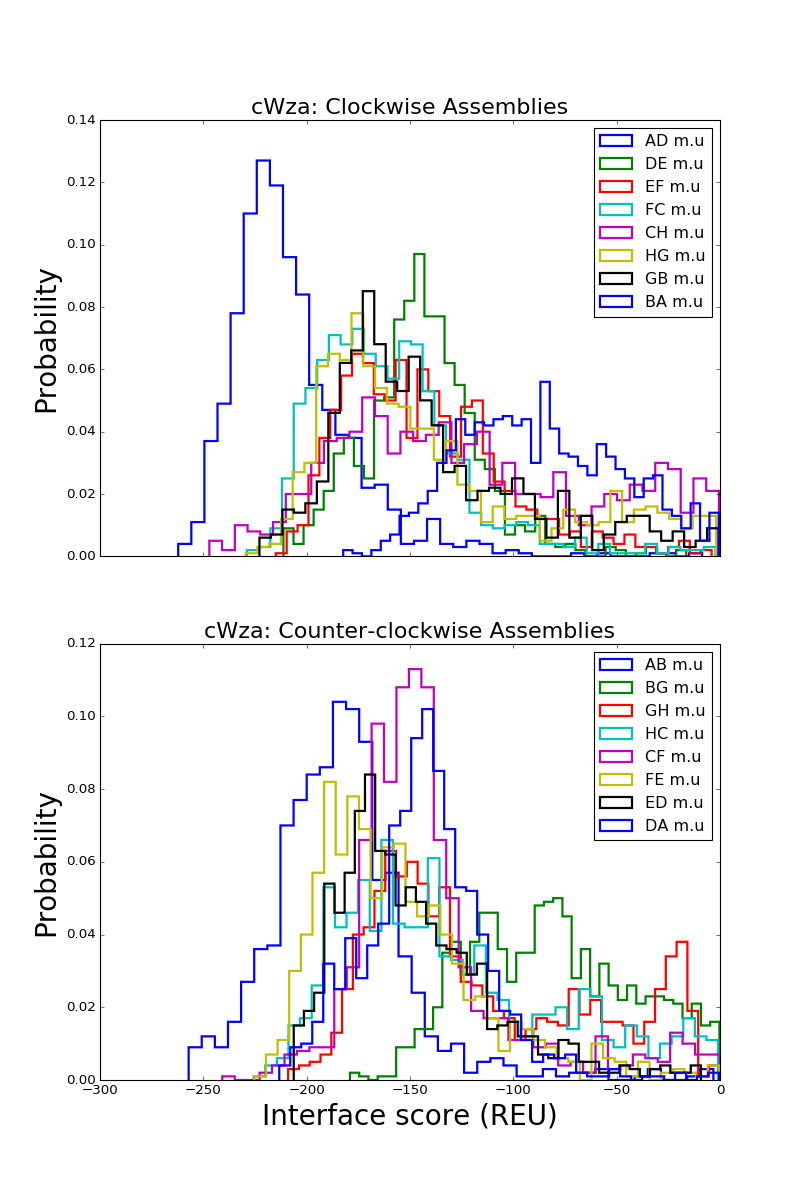

In [12]:
fig, (ax_cwise,ax_ccwise) = plt.subplots(2,1,figsize=(10,15),sharex=True)

#X = Iscs_ccwise[0]
#mu = mu_ccwise[0]
#ax_cwise.hist(X,bins=40,weights=weights4hist(X),color='blue',linewidth=0.5,label=mu+" m.u",alpha=0.3)

for n in range(8):
    X = Iscs_cwise[n]
    mu = mu_cwise[n]
    ax_cwise.hist(X,bins=40,weights=weights4hist(X),linewidth=2,histtype='step',label=mu+" m.u",alpha=1)
    
for n in range(8):
    X = Iscs_ccwise[n]
    mu = mu_ccwise[n]
    ax_ccwise.hist(X,bins=40,weights=weights4hist(X),linewidth=2,histtype='step',label=mu+" m.u",alpha=1)

ax_cwise.set_title("cWza: Clockwise Assemblies",fontsize=20)
ax_cwise.legend()
ax_cwise.set_ylabel("Probability", fontsize=25)

ax_ccwise.set_title("cWza: Counter-clockwise Assemblies",fontsize=20)
ax_ccwise.legend()
ax_ccwise.set_xlabel("Interface score (REU)", fontsize=25)
ax_ccwise.set_ylabel("Probability", fontsize=25)

plt.show()

In [46]:
d_chains_com_bb_cwise = {}
d_chains_com_sc_cwise = {}

d_chains_com_bb_ccwise = {}
d_chains_com_sc_ccwise = {}

for n in range(8):
    d_chains_com_bb_cwise[n] = []
    d_chains_com_sc_cwise[n] = []
    name = mu_cwise[n]
    for k in range(1000):
        try:
            protein =  isambard_dev.ampal.convert_pdb_to_ampal(
                "input_thorough/refined1_thorough_0001_"+name+"_INPUT_"+format(k+1,'04d')+"_ignorechain.pdb")
            # Protein COM
            com_protein_bb = protein.backbone.centre_of_mass
            # COM for first chain bb and with sc
            com_chain_bb = protein[0].backbone.centre_of_mass
            com_chain_sc = protein[0].centre_of_mass
            # Distance from Protein COM to single-chain COM 
            d_chains_com_bb_cwise[n].append(numpy.linalg.norm(com_chain_bb - com_protein_bb))
            d_chains_com_sc_cwise[n].append(numpy.linalg.norm(com_chain_sc - com_protein_bb))
        except:
            d_chains_com_bb_cwise[n].append("None")
            d_chains_com_sc_cwise[n].append("None")

with open('data_d_chains_com_bb_cwise.json', 'w') as fp:
    json.dump(d_chains_com_bb_cwise, fp)
    
with open('data_d_chains_com_sc_cwise.json', 'w') as fp:
    json.dump(d_chains_com_sc_cwise, fp)
            
for n in range(8):
    d_chains_com_bb_ccwise[n] = []
    d_chains_com_sc_ccwise[n] = []
    name = mu_ccwise[n]
    for k in range(1000):
        try:
            protein =  isambard_dev.ampal.convert_pdb_to_ampal(
                "input_thorough/refined1_thorough_0001_"+name+"_INPUT_"+format(k+1,'04d')+"_ignorechain.pdb")
            # Protein COM
            com_protein_bb = protein.backbone.centre_of_mass
            # COM for first chain bb and with sc
            com_chain_bb = protein[0].backbone.centre_of_mass
            com_chain_sc = protein[0].centre_of_mass
            # Distance from Protein COM to single-chain COM 
            d_chains_com_bb_ccwise[n].append(numpy.linalg.norm(com_chain_bb - com_protein_bb))
            d_chains_com_sc_ccwise[n].append(numpy.linalg.norm(com_chain_sc - com_protein_bb))
        except:
            d_chains_com_bb_ccwise[n].append("None")
            d_chains_com_sc_ccwise[n].append("None")

with open('data_d_chains_com_bb_ccwise.json', 'w') as fp:
    json.dump(d_chains_com_bb_ccwise, fp)
    
with open('data_d_chains_com_sc_ccwise.json', 'w') as fp:
    json.dump(d_chains_com_sc_ccwise, fp)

<IPython.core.display.Javascript object>


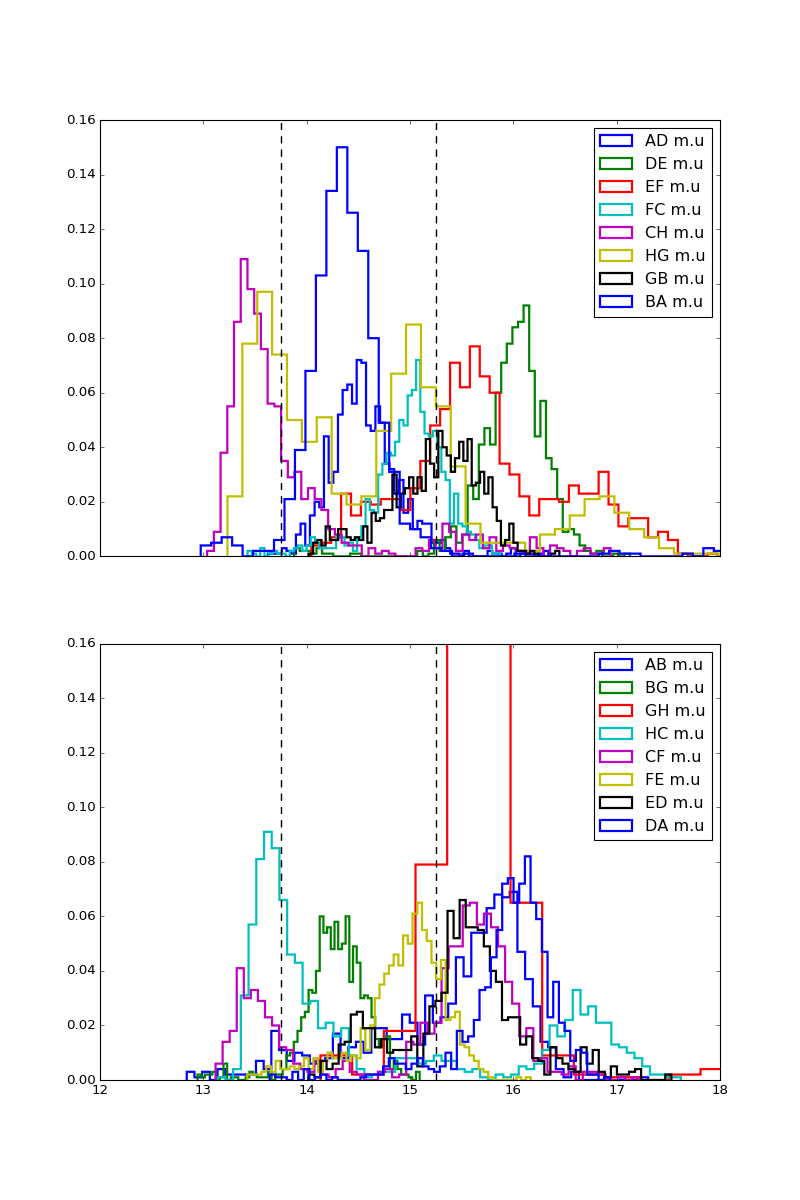

In [67]:
fig, (ax_cwise,ax_ccwise) = plt.subplots(2,1,figsize=(10,15),sharex=True)

#plt.title("cWza: all docked models",fontsize=25)
#plt.xlabel("Assembly-COM-to-Chain-COM distance ($\AA$)",fontsize=20)
#plt.ylabel("Absolute frequency",fontsize=20)

for n in range(8):
    X = d_chains_com_bb_cwise[n]
    mu = mu_cwise[n]
    ax_cwise.hist(X,bins=60,weights=weights4hist(X),linewidth=2,histtype='step',label=mu+" m.u",alpha=1)
    #ax_cwise.hist(X,bins=60,weights=weights4hist(X),linewidth=2,histtype='step',label=mu+" m.u",alpha=1)
    ax_cwise.plot((13.75,13.75),(0,0.180),linestyle='--',alpha=0.5,color='black')
    ax_cwise.plot((15.25,15.25),(0,0.180),linestyle='--',alpha=0.5,color='black')
    
ax_cwise.legend()
ax_cwise.set_ylim(0,0.16)

for n in range(8):
    X = d_chains_com_bb_ccwise[n]
    mu = mu_ccwise[n]
    ax_ccwise.hist(X,bins=60,weights=weights4hist(X),linewidth=2,histtype='step',label=mu+" m.u",alpha=1)
    #ax_ccwise.hist(X,bins=60,weights=weights4hist(X),linewidth=2,histtype='step',label=mu+" m.u",alpha=1)
    ax_ccwise.plot((13.75,13.75),(0,0.180),linestyle='--',alpha=0.5,color='black')
    ax_ccwise.plot((15.25,15.25),(0,0.180),linestyle='--',alpha=0.5,color='black')

ax_ccwise.legend()
ax_ccwise.set_xlim(12,18)
ax_ccwise.set_ylim(0,0.16)

plt.show()

<IPython.core.display.Javascript object>


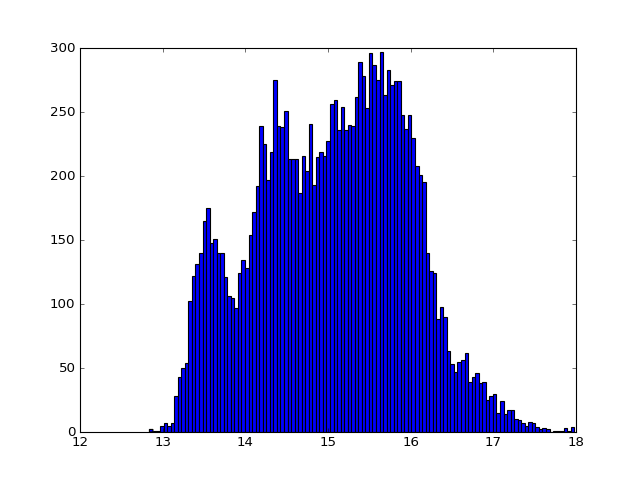

In [81]:
figg = plt.figure()

#plt.title("cWza: all docked models",fontsize=25)
#plt.xlabel("Assembly-COM-to-Chain-COM distance ($\AA$)",fontsize=20)
#plt.ylabel("Absolute frequency",fontsize=20)
data = []

for n in range(8):
    X = [x for x in d_chains_com_bb_cwise[n] if x < 18]
    data = data + X

for n in range(8):
    X = [x for x in d_chains_com_bb_ccwise[n] if x < 18]
    data = data + X

plt.hist(data,120)
plt.xlim(12,18)

plt.show()

## Conductance


In [82]:
pdbnames_cwise = {}
pdbnames_ccwise = {}

for n in range(8):
    infile_cwise  = open('pdblist_'+mu_cwise[n]+'chains_refined1_thorough.txt','r')
    infile_ccwise = open('pdblist_'+mu_ccwise[n]+'chains_refined1_thorough.txt','r')
    pdbnames_cwise[n]  = [ l.rstrip() for l in infile_cwise.readlines()]
    pdbnames_ccwise[n] = [ l.rstrip() for l in infile_ccwise.readlines()]

In [84]:
ids_cwise = {}
ids_ccwise = {}

for k in range(8):
    ids_cwise[k] = []
    ids_ccwise[k] = []
    for i in range(1000):
        try:
            mid_cwise  = sessions_cwise[k].query(Pdb.id).filter_by(pdb_name=pdbnames_cwise[k][i]).first()
            ids_cwise[k].append(mid_cwise[0])
        except:
            ids_cwise[k].append("None")
        try:
            mid_ccwise = sessions_ccwise[k].query(Pdb.id).filter_by(pdb_name=pdbnames_ccwise[k][i]).first()
            ids_ccwise[k].append(mid_ccwise[0])
        except:
            ids_ccwise[k].append("None")

In [87]:
Gpreds_cwise = {}
VDW_Rmin_cwise = {}

for k in range(8):
    Gpreds_cwise[k] = []
    VDW_Rmin_cwise[k] = []
    for id in ids_cwise[k]:
        try:
            #G = sessions_Trials[n].query(HOLE_Output.Gpred_Rmin).filter_by(id = id).one()
            G = sessions_cwise[k].query(HOLE_Output.Gpred_Rmin).filter_by(id = id).one()
            Gpreds_cwise[k].append(G[0])
        except:
            Gpreds_cwise[k].append("None")
        try:
            Rmin = sessions_cwise[k].query(HOLE_Output.HOLE_Rmin).filter_by(id = id).one()
            VDW_Rmin_cwise[k].append(Rmin[0])
        except:
            VDW_Rmin_cwise[k].append("None")

with open('Gpred_Rmin_cwise.json', 'w') as fp:
    json.dump(Gpreds_cwise, fp)
            
Gpreds_ccwise = {}
VDW_Rmin_ccwise = {}

for k in range(8):
    Gpreds_ccwise[k] = []
    VDW_Rmin_ccwise[k] = []
    for id in ids_ccwise[k]:
        try:
            #G = sessions_Trials[n].query(HOLE_Output.Gpred_Rmin).filter_by(id = id).one()
            G = sessions_ccwise[k].query(HOLE_Output.Gpred_Rmin).filter_by(id = id).one()
            Gpreds_ccwise[k].append(G[0])
        except:
            Gpreds_ccwise[k].append("None")
        try:
            Rmin = sessions_ccwise[k].query(HOLE_Output.HOLE_Rmin).filter_by(id = id).one()
            VDW_Rmin_ccwise[k].append(Rmin[0])
        except:
            VDW_Rmin_ccwise[k].append("None")
            
with open('Gpred_Rmin_ccwise.json', 'w') as fp:
    json.dump(Gpreds_ccwise, fp)

<IPython.core.display.Javascript object>


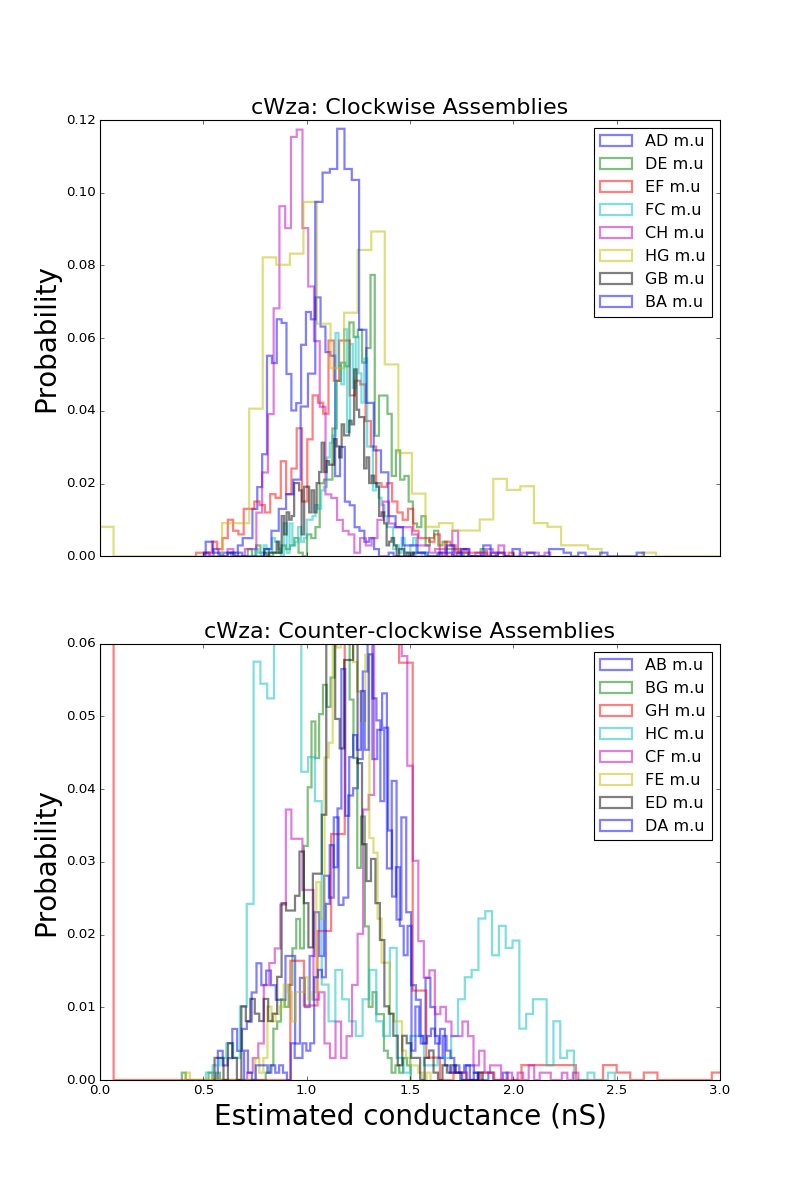

In [93]:
fig2, (ax_cwise,ax_ccwise) = plt.subplots(2,1,figsize=(10,15), sharex=True)


for n in range(8):
    X = [x for x in rm_none(Gpreds_cwise[n]) if x < 4]
    mu = mu_cwise[n]
    ax_cwise.hist(X,bins=60,weights=weights4hist(X),linewidth=2,histtype='step',label=mu+" m.u",alpha=0.5)
    
for n in range(8):
    X = [x for x in rm_none(Gpreds_ccwise[n]) if x < 4]
    mu = mu_ccwise[n]
    ax_ccwise.hist(X,bins=60,weights=weights4hist(X),linewidth=2,histtype='step',label=mu+" m.u",alpha=0.5)


ax_cwise.set_title("cWza: Clockwise Assemblies",fontsize=20)
ax_cwise.legend()
ax_cwise.set_ylabel("Probability", fontsize=25)
#ax_cwise.set_ylim(0,0.13)

ax_ccwise.set_title("cWza: Counter-clockwise Assemblies",fontsize=20)
ax_ccwise.legend()
ax_ccwise.set_xlabel("Estimated conductance (nS)", fontsize=25)
ax_ccwise.set_ylabel("Probability", fontsize=25)
ax_ccwise.set_xlim(0,3)

plt.show()

<IPython.core.display.Javascript object>


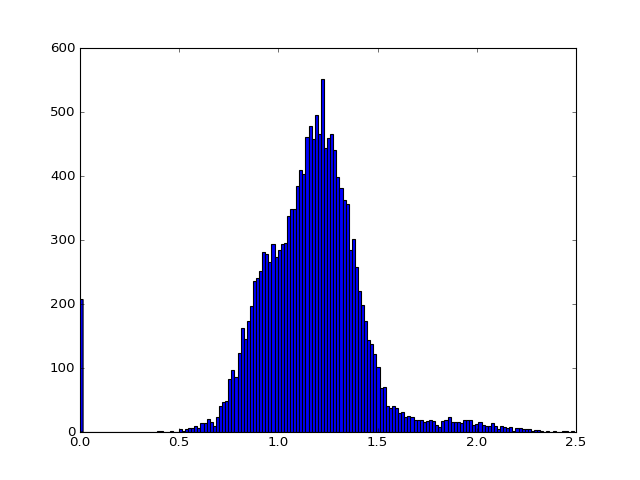

In [97]:
figgg = plt.figure()

#plt.title("cWza: all docked models",fontsize=25)
#plt.xlabel("Assembly-COM-to-Chain-COM distance ($\AA$)",fontsize=20)
#plt.ylabel("Absolute frequency",fontsize=20)
data = []

for n in range(8):
    X = [x for x in rm_none(Gpreds_cwise[n]) if x < 2.5]
    data = data + X

for n in range(8):
    X = [x for x in rm_none(Gpreds_ccwise[n]) if x < 2.5]
    data = data + X

plt.hist(data,160)
#plt.xlim(12,18)

plt.show()

15894

<IPython.core.display.Javascript object>


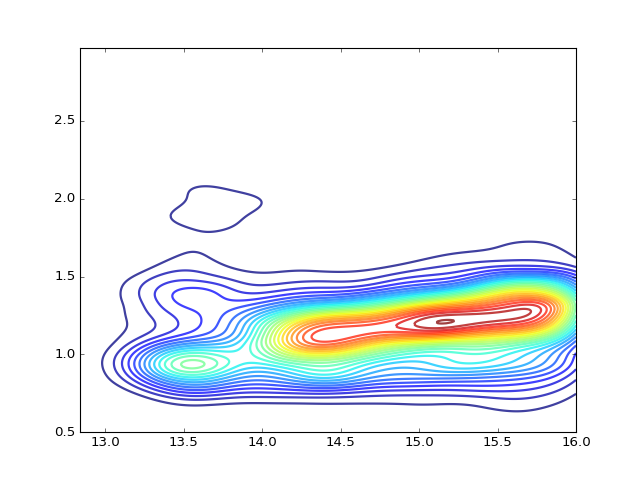

In [115]:
figgg = plt.figure()

X_all = []
Y_all = []

for n in range(8):
    X, Y = filter_missing_data([d_chains_com_bb_cwise[n], Gpreds_cwise[n]])
    X_all = X_all + X
    Y_all = Y_all + Y
    
for n in range(8):
    X, Y = filter_missing_data([d_chains_com_bb_ccwise[n], Gpreds_ccwise[n]])
    X_all = X_all + X
    Y_all = Y_all + Y

dataa = [(X_all[n], Y_all[n]) for n in range(15894) if X_all[n] < 16]
    
XX,YY = numpy.array(dataa).T
    
dataaa = [(XX[n], YY[n]) for n in range(len(XX)) if 0.5 < YY[n] < 3]
    
XXX,YYY = numpy.array(dataaa).T

X0,Y0,Z0 = density_estimation(XXX,YYY)

plt.contour(X0,Y0,Z0,30,linestyles='solid',linewidths=2,alpha=0.75)
#plt.scatter(XXX,YYY,alpha=0.1)

plt.show()

<IPython.core.display.Javascript object>


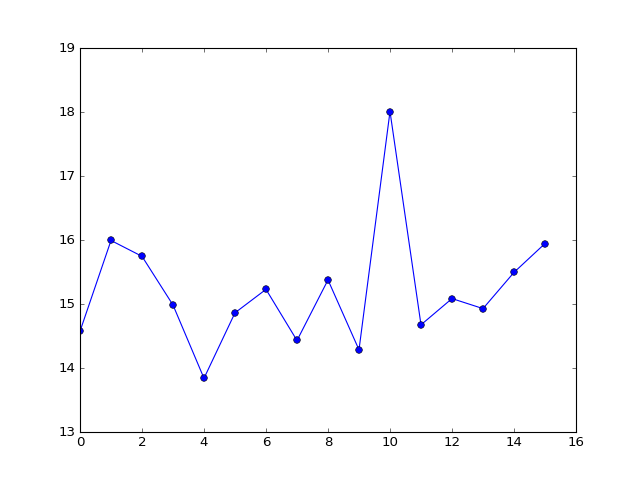

In [75]:
fig_all = plt.figure()
#plt.title("cWza: all docked models",fontsize=25)
#plt.xlabel("Assembly-COM-to-Chain-COM distance ($\AA$)",fontsize=20)
#plt.ylabel("Absolute frequency",fontsize=20)
all_cwise = []
all_ccwise = []
error_all = []

for n in range(8):
    X = d_chains_com_bb_cwise[n]
    Y = d_chains_com_bb_ccwise[n]
    #mu = mu_cwise[n]
    all_cwise.append(numpy.mean(X))
    all_ccwise.append(numpy.mean(Y))

plt.plot(all_cwise+all_ccwise,marker='o')

plt.show()

In [ ]:
d_chains_com_bb_ccwise_all = []
for n in range(7):
    d_chains_com_bb_ccwise_all = d_chains_com_bb_ccwise_all + d_chains_com_bb_ccwise[n]

In [ ]:
fig_d_bb_all = plt.figure(dpi=80)
XX = [x for x in d_chains_com_bb_ccwise_all if x < 20]
plt.hist(XX,100)
plt.show()

In [ ]:
fig_conf = plt.figure()
for n in range(2):
    x = [phi[n][0][i][1] for i in range(30)]
    y = [psi[n][0][i][1] for i in range(30)]
    plt.scatter(x,y,c = numpy.random.rand(3,1),s=numpy.array(range(30))**2)

plt.scatter(mydata1[0][0],mydata1[0][1],c='blue',s=numpy.array(range(30))**2)
plt.show()

In [ ]:
allmodels_Isc = session.query(RosettaMP_Energies.I_sc).all()
Isc_all = list([v[0] for v in allmodels_Isc])

fig5 = plt.figure()
# Customize plot
plt.title("cWza: All MPSymDock models", fontsize=20)
plt.xlabel("RosettaMP score (REU)", fontsize=20)
#plt.xlim(-300,0)
plt.ylabel("Probability", fontsize=20)
#plt.ylim(0,0.12)

plt.hist(Isc_all, bins=40,color='orange',weights=weights4hist(Isc_all))
plt.show()

Work out mean and std values of energy for all groups and individual ones

### Energy funnel for all models

In [ ]:
infile = open('pdblist_DAchains_refined1_thorough.txt', 'r')
pdbnames = [ l.rstrip() for l in infile.readlines()]

## HOLE conductance per group

Obtain all HOLE Gpred(Rmin) values for all MPSymDock structures

In [ ]:

model_ids = []
for n in range(1,1001):
    mid = session.query(Pdb.id).filter_by(
        pdb_name='input_thorough/refined1_thorough_0001_DA_INPUT_'+str(format(n,'04d'))+'_ignorechain.pdb' ).first()
    model_ids.append(mid[0])

Gpred_Rmin_all = []
for id in model_ids:
    try:
        model_Gpred_Rmin = session.query(HOLE_Output.Gpred_Rmin).filter_by(id = id).one()
        Gpred_Rmin_all.append(model_Gpred_Rmin[0])
    except:
        Gpred_Rmin_all.append("None")


Plot histogram of conductance values for all structures

In [ ]:
Gpred_Rmin_all = [float(v) for v in Gpred_Rmin_all if v != 'None']

fig10 = plt.figure()

# Customize plot
plt.title("cWza: All MPSymDock models", fontsize=20)
plt.xlabel("HOLE Gpred (Rmin) [nS]", fontsize=20)

plt.ylabel("Absolute frequency", fontsize=20)

plt.hist(Gpred_Rmin_all, bins=60,color='orange')

plt.show()

Fit linear combination of gaussians to bimodal distribution from all-conductances histrogram. Determine the mean  and standard deviation values for each gaussian mode. 

Conductance by **SH-group** separation: 

In [ ]:
d_chains_com_bb = []
d_chains_com_sc = []

for n in range(1000):
    protein =  isambard_dev.ampal.convert_pdb_to_ampal(
        "input_thorough/refined1_thorough_0001_DA_INPUT_"+format(n+1,'04d')+"_ignorechain.pdb")
    # Protein COM
    com_protein_bb = protein.backbone.centre_of_mass
    # COM for first chain bb and with sc
    com_chain_bb = protein[0].backbone.centre_of_mass
    com_chain_sc = protein[0].centre_of_mass
    # Distance from Protein COM to single-chain COM 
    d_chains_com_bb.append(numpy.linalg.norm(com_chain_bb - com_protein_bb))
    d_chains_com_sc.append(numpy.linalg.norm(com_chain_sc - com_protein_bb))

In [ ]:
fig_d = plt.figure(dpi=80)

plt.title("cWza: all docked models",fontsize=25)
plt.xlabel("Assembly-COM-to-Chain-COM distance ($\AA$)",fontsize=20)
plt.ylabel("Absolute frequency",fontsize=20)

plt.hist(d_chains_com_bb,bins=60,color='yellow',alpha=0.75,label='Chain-BB')
plt.hist(d_chains_com_sc,bins=60,color='black',alpha=0.5,label='Chain w/SC')

plt.legend()
plt.show()

### Assessing statistical significance with respect to experiments

1 Need to find first the amount of models that belong to each conductance group.

Work out the cut-off between both normal distributions, then filter out the amount of models whose conductance are either below (low conductance group) or above (high-conductance group) the cut-off.

## Energies for conductance state groups

Filter out energies of all models per conductance group, provided model ids

1 Collect information regarding id, conductance value, pdb name, and interfacial energy for all models separated by conductance cutoff

2 From each conductance group, regardless of their structural group, FIRST pick models with G values close to the mean values by half of the std from each mode in general distribution of conductances.

**Step 4** 
Filter out top 20 models with lowest interfacial energies per conductive group

# Interface energy and HOLE conductance scatter plot

In [ ]:
fig_100 = plt.figure()
plt.xlim(-300,0)
plt.ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
plt.xlabel("Interface energy [REU]", fontsize=20)
#plt.scatter(aa_rmsd_refined1[:-3], Gpred_Rmin_all, color='black', alpha=0.7)
plt.scatter(Isc_all, Gpred_Rmin_all, color='orange', alpha=0.9)
#plt.plot((-300,0),(1.11,1.11),linestyle='--',color='black',alpha=0.75)

plt.plot()

In [ ]:
from scipy.stats import gaussian_kde

x = Isc_all[:-3]
y = Gpred_Rmin_all
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig = plt.figure()
plt.title("cWza: All MPSymDock models", fontsize=20)
plt.xlim(-250,0)
plt.ylim(0,2)
plt.ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
plt.xlabel("Interface energy [REU]", fontsize=20)
plt.scatter(x, y, c=z, s=50, edgecolor='')
#plt.plot((-300,0),(1.11,1.11),linestyle='--',color='black',alpha=0.75)

plt.plot()


In [ ]:
from scipy.stats import gaussian_kde

def density_estimation(m1,m2):
    xmin=min(m1)
    xmax=max(m1)
    ymin=min(m2)
    ymax=max(m2)
    X, Y = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X,Y,Z

In [ ]:
def rm_none(data):
    return [x for x in data if x!='None']

In [ ]:
#X = [Isc_all[i] for i in range(1000) if Gpred_Rmin_all[i]!='None']
X = Isc_all[:-3]
Y = rm_none(Gpred_Rmin_all)
datacontour = list(density_estimation(X,Y))

In [ ]:
XX,YY,ZZ = datacontour

In [ ]:

fig = plt.figure()
plt.scatter(X,Y,color='black',alpha=0.1)
plt.ylim(0.6,1.8)
plt.xlabel("Interface score [REU]",fontsize=25)
plt.xlim(-300,0)
plt.ylabel("HOLE Gpred(Rmin) [nS]",fontsize=25)
plt.contour(XX,YY,ZZ,25,linewidths=2)

plt.plot((-300,0),(0.933,0.933),color='red',linestyle='--',lw=2,label='$\mu_G$: mode 0')
plt.plot((-300,0),(1.267,1.267),color='blue',linestyle='--',lw=2,label='$\mu_G$: mode 1')

#plt.title("cWza", fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Find out origin of biomodal distribution of conductances

Get minimum radii and plot

In [ ]:
VDWRmin_all = []
for id in model_ids:
    try:
        model_VDWRmin = session.query(HOLE_Output.HOLE_Rmin).filter_by(id = id).one()
        VDWRmin_all.append(model_VDWRmin[0])
    except:
        VDWRmin_all.append("None")


In [ ]:
hist_rmin = plt.figure()
plt.xlabel("HOLE Rmin ($\AA$)", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist([v for v in VDWRmin_all if v != 'None'], bins=60, color='orange')
plt.show()

Analyse integrated aspect ratio 

In [ ]:
Gmacro_all = []
for id in model_ids:
    try:
        model_Gmacro = session.query(HOLE_Output.Gmacro).filter_by(id = id).one()
        Gmacro_all.append(model_Gmacro[0])
    except:
        Gmacro_all.append("None")

In [ ]:
hist_gmacro = plt.figure()

plt.xlabel("HOLE Gmacro ($\AA$)", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist([v for v in Gmacro_all if v != 'None'], bins=50, color='orange')
plt.show()

In [ ]:
tseries_gmacro = plt.figure()

plt.xlabel("Model number", fontsize=20)
plt.ylabel("HOLE Gmacro [nS]", fontsize=20)
plt.plot([v for v in Gmacro_all if v != 'None'], color='orange', c = 'orange', linestyle='None', marker='o')
plt.show()

In [ ]:
len(Gpred_Rmin_all)

In [ ]:
fig_gmacro_groupsep = plt.figure()

#plt.xlim(0,1000)
#plt.ylim(1000,2500)

for n in Gpred_Rmin_Low_indeces:
    plt.scatter(n, Gpred_Rmin_all[n], color='yellow', alpha=1)
    
for n in Gpred_Rmin_High_indeces:
    plt.scatter(n, Gpred_Rmin_all[n], color='black', alpha=1)    

plt.show()



This gives us some idea about the quality of the fitting ...

# HOLE computed VDW Radii for all structures

In [ ]:
import re
HOLE_Z_VDWR = []
for pdb in pdbnames:
    hole_z = []
    hole_vdwr = []
    infile = open(pdb[:-3]+"hole_dat", "r")
    lines = infile.readlines()
    for l in lines:
        if re.search(r"mid-", l):
            a, b = l.split()[0:2]
            hole_z.append(float(a))
            hole_vdwr.append(float(b))
    HOLE_Z_VDWR.append([hole_z, hole_vdwr])            


In [ ]:
def parallel_ref_axis(ampal):
    prims = numpy.array([x.coordinates for x in ampal.primitives])
    ref_axis = isambard.ampal.pseudo_atoms.Primitive.from_coordinates(
        numpy.mean(prims, axis=0))
    return ref_axis

In [ ]:
import os, numpy, sys
from numpy.linalg import norm
import isambard_dev

def get_mySHparams(protein): 
	sequence = protein[0].sequence
	residue_ids = [protein[0][i].id for i in range(len(protein[0].sequence))]
	reference_axis = parallel_ref_axis(protein)
	residue_code =  [sequence[n]+str(n+1)  for n in range(len(sequence))]

	N_chains = len(protein.sequences)
	# Calculate mean radius just for residues in range
	data = []
	for n in range(N_chains):
		chain = protein[n]
		radius_list = isambard_dev.analyse_protein.polymer_to_reference_axis_distances(chain, reference_axis)
		data.append(radius_list)

	data = numpy.array(data).T
	mean_radii      = list(numpy.mean(data, axis=1))
	std_radii       = list(numpy.std(data, axis=1))
	ca_radii = [[residue_code[n], mean_radii[n], std_radii[n]] for n in range(len(residue_code))]

	# Get cylindrical azimuthal phi-angle (radians)
	data = []
	ra_xyz     = reference_axis.coordinates
	for n in range(N_chains):
		chain = protein[n]
		protein_xyz     = chain.primitive.coordinates
		r0 = protein_xyz[0] - ra_xyz[0]
		data_per_chain = []
		data_per_chain.append(0)
		for j in range(1,len(protein_xyz)):
			distance2axis   = protein_xyz[j] - ra_xyz[j]
			cos_angle       = numpy.dot(r0, distance2axis)/(norm(r0)*norm(distance2axis))
			phi_angle       = numpy.rad2deg(numpy.arccos(cos_angle))
			data_per_chain.append(phi_angle)
		data.append(data_per_chain)

	data = numpy.array(data).T
	mean_phis       = list(numpy.mean(data, axis=1))
	std_phis        = list(numpy.std(data, axis=1))
	azimuthal_angles = [[residue_code[n], mean_phis[n], std_phis[n]] for n in range(len(residue_code))]	

	# Get CA positions relative to reference axis
	ra_xyz = reference_axis.coordinates
	L = [norm(r - ra_xyz[0]) for r in ra_xyz]
	
	# Get interface angles 
	data = []
	for n in range(N_chains):
		chain = protein[n]
		protein_xyz = chain.primitive.coordinates
		crangles = isambard_dev.analyse_protein.crick_angles(chain, reference_axis)
		crangles = [x for x in crangles if x is not None]
		data.append(crangles)

	data = numpy.array(data).T
	mean_crangles   = list(numpy.mean(data, axis=1))
	mean_crangles.append('None')
	std_crangles    = list(numpy.std(data, axis=1))
	std_crangles.append('None')
	interface_angles = [[residue_code[n], mean_crangles[n], std_crangles[n]] for n in range(len(residue_code))]

	return ca_radii, azimuthal_angles, L, interface_angles

In [ ]:
p = isambard_dev.ampal.convert_pdb_to_ampal('input/refined1_0001_INPUT_1000_ignorechain.pdb')

In [ ]:
import numpy
new_refaxis = parallel_ref_axis(p)

In [ ]:
ca_radii, azimuthal_angles, L, interface_angles = get_SHparams(p)

In [ ]:
x = numpy.array(ca_radii).T[1]
y = numpy.array(azimuthal_angles).T[1]
z = L

In [ ]:
minr = np.array(HOLE_Z_VDWR[999][0]).min()
maxr = np.array(HOLE_Z_VDWR[999][0]).max()
print(minr, maxr)
t = 0.5*(maxr + minr)
print(t)

In [ ]:
print(t)

In [ ]:
np.array(z).max()

In [ ]:
zz = np.array(z) 
minrr = zz.min()
maxrr = zz.max()
print(minrr, maxrr)
t = 0.5*(minrr + maxrr)
print(t)

In [ ]:
fig_vdwr_all = plt.figure(figsize=(12,8))
import numpy
plt.ylim(0,20)
plt.xlim(-25,25)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW radial distance [$\AA$]", fontsize=25)
plt.title("VDW Radial profile: MPSymDock model 1000", fontsize=25)

for n in [999]:
    colors= numpy.random.rand(3,1)
    plt.scatter(np.array(HOLE_Z_VDWR[n][0])-1.54764, HOLE_Z_VDWR[n][1], c='blue',s=50, color='blue',label='VDW' )
#plt.scatter(zz-13, x, color='green',s=50, label='Atomic')
#plt.axes().set_aspect('equal', 'datalim')
plt.legend()
plt.show()

Separate VDW Radial profiles by **groups** classified in the **SH-paramter space**

In [ ]:
vdwr_group0 = np.asarray(HOLE_Z_VDWR)[np.asarray(labels) == 0]
vdwr_group1 = np.asarray(HOLE_Z_VDWR)[np.asarray(labels) == 1]
vdwr_group2 = np.asarray(HOLE_Z_VDWR)[np.asarray(labels) == 2]

In [ ]:
vdwr_groups_plot = plt.figure(figsize=(12,8))

plt.ylim(0,18)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW Radius [$\AA$]", fontsize=20)
plt.title("Group separation: VDW Radial profile", fontsize=20)


for n in range(len(vdwr_group0)):
    plt.plot(vdwr_group0[n][0], vdwr_group0[n][1], color='blue', alpha=0.2)

#for n in range(len(vdwr_group1)):
#    plt.plot(vdwr_group1[n][0], vdwr_group1[n][1], color='green', alpha=0.5)
    
for n in range(len(vdwr_group2)):
    plt.plot(vdwr_group2[n][0], vdwr_group2[n][1], color='red', alpha=0.9)

plt.show()

In [ ]:
vdwr_groups_plot = plt.figure(figsize=(12,8))

plt.ylim(0,18)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW Radius [$\AA$]", fontsize=20)
plt.title("Group separation: VDW Radial profile", fontsize=20)


#for n in range(len(vdwr_group0)):
#    plt.plot(vdwr_group0[n][0], vdwr_group0[n][1], color='blue', alpha=0.2)

for n in range(len(vdwr_group1)):
    plt.plot(vdwr_group1[n][0], vdwr_group1[n][1], color='green', alpha=0.5)
    
for n in range(len(vdwr_group2)):
    plt.plot(vdwr_group2[n][0], vdwr_group2[n][1], color='red', alpha=0.9)

plt.show()

Separate profiles discriminating between **Low and High conductance groups**

In [ ]:
Gpred_Rmin_High_indeces = []

for id in Gpred_Rmin_High_ids:
    name = session.query(Pdb.pdb_name).filter_by(id = id).one()
    Gpred_Rmin_High_indeces.append( int(name[0].split("_")[3])-1) 
    
Gpred_Rmin_Low_indeces = []

for id in Gpred_Rmin_Low_ids:
    name = session.query(Pdb.pdb_name).filter_by(id = id).one()
    Gpred_Rmin_Low_indeces.append( int(name[0].split("_")[3])-1) 


In [ ]:
print(len(Gpred_Rmin_High_indeces), len(Gpred_Rmin_Low_indeces))

In [ ]:
fig_vdwr_Gpred_Rmin_High = plt.figure(figsize=(12,8))

plt.ylim(0,18)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW Radius [$\AA$]", fontsize=20)
plt.title("High conductance group: VDW Radial profile", fontsize=20)


    
for n in Gpred_Rmin_Low_indeces:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='yellow', alpha=1)
    
for n in Gpred_Rmin_High_indeces:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='black', alpha=0.1)    
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

Separate groups in **SH-parameters** space by **conductance group**


In [ ]:
# Define figure size and type
fig_shg = plt.figure(figsize=(10,8), dpi=80)
axsh = fig_shg.add_subplot(111,projection='3d')

# Customize plot appereance
axsh.set_title('Superhelical Paremeters: cWza*',fontsize=20)
axsh.set_xlabel("CA Radius p.r.c [$\AA$]",fontsize=15)
axsh.set_ylabel("Azimuthal angle p.r.c [deg]",fontsize=15)
axsh.set_zlabel("Helical axial position p.r.c [$\AA$]",fontsize=15)

# Plot all curves in superhelical-parameter space per structure 
for i in Gpred_Rmin_Low_ids_stddist:
    x = np.array([v[1] for v in allmodels_rad[i]])
    y = np.array([v[1] for v in allmodels_azim[i]])
    z = [v[1] for v in allmodels_iangles[i][:-1]]
#    z = np.array(allmodels_z[i])
    axsh.plot(x[:-1],y[:-1],z, color='yellow')

for i in Gpred_Rmin_High_ids_stddist:
    x = np.array([v[1] for v in allmodels_rad[i]])
    y = np.array([v[1] for v in allmodels_azim[i]])
    z = np.array([float(v[1]) for v in allmodels_iangles[i][:-1]])
    #z = np.array(allmodels_z[i])
    #print(x, y, z)
    axsh.plot(x[:-1],y[:-1],z, color='black', alpha=0.5)


plt.show()

**Question**: What proportion of models from each conductance group make up each SH group?

In [ ]:
model_ids_group0 = np.asarray(model_ids)[np.asarray(labels) == 0]
model_ids_group1 = np.asarray(model_ids)[np.asarray(labels) == 1]
model_ids_group2 = np.asarray(model_ids)[np.asarray(labels) == 2]

In [ ]:
int0low = set(model_ids_group0).intersection(set(Gpred_Rmin_Low_ids))
int0high = set(model_ids_group0).intersection(set(Gpred_Rmin_High_ids))

print("Intersection SH-group 0 (blue) and Low/High conductance groups: ",\
      len(int0low),len(int0high), len(int0low)/len(int0high))

int1low = set(model_ids_group1).intersection(set(Gpred_Rmin_Low_ids))
int1high = set(model_ids_group1).intersection(set(Gpred_Rmin_High_ids))
print("Intersection SH-group 1 (green) and Low/High conductance groups: ",\
      len(int1low),len(int1high), len(int1low)/len(int1high))

int2low = set(model_ids_group2).intersection(set(Gpred_Rmin_Low_ids))
int2high = set(model_ids_group2).intersection(set(Gpred_Rmin_High_ids))
print("Intersection SH-group 2 (red) and Low/High conductance groups: ",\
      len(int2low),len(int2high), len(int2low)/len(int2high))

Differentiate between sidechain interface angles by conductance group

In [ ]:
s1 = set(Gpred_Rmin_High_ids_stddist)
s2 = set(Gpred_Rmin_Low_ids_stddist)
ss = s1.intersection(s2)
print(ss)

In [ ]:
# Define figure size and type
fig1 = plt.figure(figsize=(12,7))

# Customize plot appereance
plt.xlim(0,31)
plt.xlabel("Residue Number",fontsize=20)
plt.xticks(range(1,31),sequence,fontsize=15)
plt.ylim(-200,200)
plt.ylabel("Interface angle [deg]",fontsize=20)
plt.yticks(fontsize=15)

# Plot interface angle values per structure
#for i in Gpred_Rmin_Low_ids_stddist :
#    a = [v[1] for v in allmodels_iangles[i]]
#    b = [v[2] for v in allmodels_iangles[i]]
#    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.75,color='yellow' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')

for i in Gpred_Rmin_High_ids_stddist :
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.75,color='black' )
    plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')
    
# Draw vertical dashed lines
#for i in range(1,31):
#    plt.plot((i,i),(-200,200),linestyle='--',color='black',alpha=0.75)


plt.show()

In [ ]:
# Define figure size and type
fig1 = plt.figure(figsize=(12,7))

# Customize plot appereance
#plt.xlim(0,31)
plt.xlabel("Residue Number",fontsize=20)
#plt.xticks(range(1,31),sequence,fontsize=15)
#plt.ylim(-200,200)
plt.ylabel("Interface angle [deg]",fontsize=20)
plt.yticks(fontsize=15)

# Plot interface angle values per structure
for i in Gpred_Rmin_Low_ids_stddist :
    #x = np.array([v[1] for v in allmodels_rad[i]])
    #x = np.array([v[1] for v in allmodels_azim[i]])
    x = np.array(allmodels_z[i])
    a = [v[1] for v in allmodels_iangles[i]]
    #b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(x[:-2],a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.75,color='yellow' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')

for i in Gpred_Rmin_High_ids_stddist :
    #x = np.array([v[1] for v in allmodels_rad[i]])
    #x = np.array([v[1] for v in allmodels_azim[i]])
    x = np.array(allmodels_z[i])
    a = [v[1] for v in allmodels_iangles[i]]
    #print(len(x), len(a))
    #b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(x[:-2],a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.5,color='black' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')
    
# Draw vertical dashed lines
#for i in range(1,31):
#    plt.plot((i,i),(-200,200),linestyle='--',color='black',alpha=0.75)


plt.show()

Filter out those models with conductance +/- sigma wrt mean from each mode

In [ ]:
# First mode
m1 = 0.932712
std1 = 0.097144

# Second mode
m2 = 1.267678
std2 = 0.076495



Gpred_Rmin_Low_stddist = []
Gpred_Rmin_High_stddist = []

Gpred_Rmin_Low_ids_stddist = []
Gpred_Rmin_High_ids_stddist = []

f=0.5

for id in model_ids:
    try:
        model_Gpred_Rmin = session.query(HOLE_Output.Gpred_Rmin).filter_by(id = id).one()
        G = model_Gpred_Rmin[0]
        if (G >= (m1 - f*std1)) and (G <= (m1 + f*std1)):
            Gpred_Rmin_Low_stddist.append(G)
            Gpred_Rmin_Low_ids_stddist.append(id)
        elif (G >= (m2 - f*std2)) and (VDW_TrialsG <= (m2 + f*std2)):
            Gpred_Rmin_High_stddist.append(G)
            Gpred_Rmin_High_ids_stddist.append(id)
    except:
        model_pdbname = session.query(Pdb).filter_by(id = id).one()
        print("No Conductance for model with id: ", id, model_pdbname.pdb_name)
        

In [ ]:
len(Gpred_Rmin_High_ids_stddist)

In [ ]:
fig_hist_stddist = plt.figure()
plt.hist(Gpred_Rmin_Low_stddist, bins = 10, color='black', alpha=0.75)
plt.hist(Gpred_Rmin_High_stddist, bins = 10, color='yellow', alpha=0.75)
plt.show()

In [ ]:
Gpred_Rmin_High_indeces_stddist = []

for id in Gpred_Rmin_High_ids_stddist:
    name = session.query(Pdb.pdb_name).filter_by(id = id).one()
    Gpred_Rmin_High_indeces_stddist.append( int(name[0].split("_")[3])-1) 
    
Gpred_Rmin_Low_indeces_stddist = []

for id in Gpred_Rmin_Low_ids_stddist:
    name = session.query(Pdb.pdb_name).filter_by(id = id).one()
    Gpred_Rmin_Low_indeces_stddist.append( int(name[0].split("_")[3])-1) 

1. Choose model from L group that has the lowest Interface score

In [ ]:

for id in Gpred_Rmin_Low_ids_stddist:
    name = session.query(Pdb.pdb_name).filter_by(id = id).one()


In [ ]:
p0 = isambard_dev.ampal.convert_pdb_to_ampal('cwza_NoWPN_relabeled.pdb')
def run_profit(n):
    p1 = isambard_dev.ampal.convert_pdb_to_ampal(pdbnames[n])
    data = {}
    rmsds = isambard_dev.external_programs.run_profit(p0.pdb, p1.pdb, path1=False, path2=False, path_to_cmd_file=None,
               return_pdb_string=False, align_type='all')
    data[str(pdbnames[n])] = rmsds
    return

## Compute BB RMSD between L- and H-models within 0.5$\sigma$

## VdW radial profiles from selected models

In [ ]:
fig_vdwr_Gpred_Rmin_High_stddist = plt.figure(figsize=(12,8))

plt.ylim(0,18)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW Radius [$\AA$]", fontsize=20)
plt.title("High conductance group: VDW Radial profile", fontsize=20)


    
for n in Gpred_Rmin_Low_indeces_stddist:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='yellow', alpha=1)
    
for n in Gpred_Rmin_High_indeces_stddist:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='black', alpha=0.4)    
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

In [ ]:
# Define figure size and type
fig_shg_stddist = plt.figure(figsize=(10,8), dpi=80)
axshstd = fig_shg_stddist.add_subplot(111,projection='3d')

# Customize plot appereance
axshstd.set_title('Superhelical Paremeters: cWza*',fontsize=20)
axshstd.set_xlabel("CA Radius p.r.c [$\AA$]",fontsize=15)
axshstd.set_ylabel("Azimuthal angle p.r.c [deg]",fontsize=15)
axshstd.set_zlabel("Helical axial position p.r.c [$\AA$]",fontsize=15)

# Plot all curves in superhelical-parameter space per structure 
for i in Gpred_Rmin_Low_indeces_stddist:
    x = np.array([v[1] for v in allmodels_rad[i]])
    y = np.array([v[1] for v in allmodels_azim[i]])
    z = np.array(allmodels_z[i])
    axshstd.plot(x,y,z, color='yellow')

for i in Gpred_Rmin_High_indeces_stddist:
    x = np.array([v[1] for v in allmodels_rad[i]])
    y = np.array([v[1] for v in allmodels_azim[i]])
    z = np.array(allmodels_z[i])
    axshstd.plot(x,y,z, color='black', alpha=0.5)


plt.show()

In [ ]:
# Define figure size and type
fig1_stddist = plt.figure(figsize=(12,7))

# Customize plot appereance
plt.xlim(0,31)
plt.xlabel("Residue Number",fontsize=20)
plt.xticks(range(1,31),sequence,fontsize=15)
plt.ylim(-200,200)
plt.ylabel("Interface angle [deg]",fontsize=20)
plt.yticks(fontsize=15)

# Plot interface angle values per structure
for i in Gpred_Rmin_Low_indeces_stddist :
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.75,color='yellow' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')

for i in Gpred_Rmin_High_indeces_stddist :
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.5,color='black' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')
    
# Draw vertical dashed lines
for i in range(1,31):
    plt.plot((i,i),(-200,200),linestyle='--',color='black',alpha=0.75)


plt.show()

# ignore stuff below ...

Classify using machine learning algorithm over VDW Radii and Z data

In [ ]:
X_scia = []
for i in range(len(allmodels_iangles)):
    X_scia.append([v[1] for v in allmodels_iangles[0][:-1]])

In [ ]:
from sklearn.cluster import SpectralClustering
num_clusters = 4
model = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors',assign_labels='kmeans')
labels_scia = model.fit_predict(X_scia)

In [ ]:
labels_scia

In [ ]:
# Define figure size and type
fig_scia = plt.figure(figsize=(12,7))
cmap_scia = colors.ListedColormap(['blue', 'green', 'red', 'orange'])
# Customize plot appereance
plt.xlim(0,31)
plt.xlabel("Residue Number",fontsize=20)
plt.xticks(range(1,31),sequence,fontsize=15)
plt.ylim(-200,200)
plt.ylabel("Interface angle [deg]",fontsize=20)
plt.yticks(fontsize=15)

# Plot interface angle values per structure
for i in range(len(allmodels_iangles)):
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',color = cmap_scia(labels_scia[i]),alpha=0.5)
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')

# Draw vertical dashed lines
for i in range(1,31):
    plt.plot((i,i),(-200,200),linestyle='--',color='black',alpha=0.75)  

plt.show()

In [ ]:
# Define figure size and type
fig1_stddist = plt.figure(figsize=(12,7))

# Customize plot appereance
plt.xlim(0,31)
plt.xlabel("Residue Number",fontsize=20)
plt.xticks(range(1,31),sequence,fontsize=15)
plt.ylim(-200,200)
plt.ylabel("Interface angle [deg]",fontsize=20)
plt.yticks(fontsize=15)

# Plot interface angle values per structure
for i in Gpred_Rmin_Low_indeces :
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.75,color='yellow' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')

for i in Gpred_Rmin_High_indeceslist(n*np.ones(len(HOLE_Z_VDWR[n][0]))) :
    a = [v[1] for v in allmodels_iangles[i]]
    b = [v[2] for v in allmodels_iangles[i]]
    plt.plot(range(1,len(a[:-2])+1),a[:-2],marker='o',markersize=15,linestyle='None',alpha=0.5,color='black' )
    #plt.errorbar(range(1,len(a[:-2])+1),a[:-2],yerr=b[:-2],linestyle='None')
    
# Draw vertical dashed lines
for i in range(1,31):
    plt.plot((i,i),(-200,200),linestyle='--',color='black',alpha=0.75)


plt.show()

In [ ]:
len(lenxplusy)

In [ ]:
%matplotlib notebook
figtest0 = plt.show()

plt.xlabel("Model number")
plt.ylabel("VDW Rad profile, dataset length")

plt.plot(lenxplusy, color='magenta')
         
plt.show()

In [ ]:
print(np.array(lenxplusy).min(), np.array(lenxplusy).max())

In [ ]:
X_test_VDW = np.asarray(X_test_VDW,dtype=np.float32)

In [ ]:
from sklearn.cluster import SpectralClustering
num_clusters = 2
model = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors',assign_labels='kmeans')
labels = model.fit_predict(X_test_VDW)

In [ ]:
# Define discrete colour map for each classified group
from matplotlib import colors
cmap = colors.ListedColormap(['blue', 'green'])

fig_vdwr_Gpred_Rmin_High = plt.figure(figsize=(12,8))

plt.ylim(0,18)
plt.xlabel("Z [$\AA$]", fontsize=20)
plt.ylabel("VDW Radius [$\AA$]", fontsize=20)
plt.title("High conductance group: VDW Radial profile", fontsize=20)


    
for n in Gpred_Rmin_Low_indeces:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='yellow', alpha=1)
    
for n in Gpred_Rmin_High_indeces:
    plt.plot(HOLE_Z_VDWR[n][0], HOLE_Z_VDWR[n][1], color='black', alpha=0.1)    
#plt.axes().set_aspect('equal', 'datalim')
plt.show()


### Assessing metrics from VDW Radial profiles: mean, var, variability coeff

**Mean VDW Radii**

In [ ]:
fig_vdwrmean_all = plt.figure()

plt.xlim(0,1000)

plt.xlabel("Model number", fontsize=20)
plt.ylabel("Mean VDW Radius [$\AA$]", fontsize=20)
plt.title("All MPSymDock structures: Mean VDW Radii", fontsize=20)

mean_HOLE_Z_VDWR = []
for n in range(1000):
    plt.scatter(n, np.mean(HOLE_Z_VDWR[n][1]), color='red', c='yellow', s=50, alpha=1)
    mean_HOLE_Z_VDWR.append(np.mean(HOLE_Z_VDWR[n][1]))
#plt.axes().set_aspect('equal', 'datalim')

plt.show()

In [ ]:
hist_vdwrmean = plt.figure()
plt.xlim(7,13)
plt.ylim(0,70)
plt.title("cWza: Mean VDW Radius", fontsize=25)
plt.xlabel("Mean VDW Rad [$\AA$]", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist([v for v in mean_HOLE_Z_VDWR if np.isnan(v) == False], bins = 50, color='orange', alpha=1)
plt.plot()

**Variance VDW Radii**

In [ ]:
fig_vdwrvar_all = plt.figure()

plt.xlim(0,1000)

plt.xlabel("Model number", fontsize=20)
plt.ylabel("Mean VDW Radius [$\AA$]", fontsize=20)
plt.title("All MPSymDock structures: Var VDW Radii", fontsize=20)

var_HOLE_Z_VDWR = []
for n in range(1000):
    plt.scatter(n, np.std(HOLE_Z_VDWR[n][1])**2, color='red', c='orange', s=50, alpha=1)
    var_HOLE_Z_VDWR.append(np.std(HOLE_Z_VDWR[n][1])**2)
#plt.axes().set_aspect('equal', 'datalim')

plt.show()

In [ ]:
hist_vdwrVar = plt.figure()
plt.xlim(0,12)
plt.ylim(0,120)
plt.title("cWza: All MPSymDock models", fontsize=25)
plt.xlabel("Var VDW Rad [$\AA$]", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist([v for v in var_HOLE_Z_VDWR if np.isnan(v) == False], bins = 50, color='orange', alpha=1)
plt.plot()

**Coefficient of Variation VDW Radii**

In [ ]:
fig_vdwrvar_all = plt.figure()

plt.xlim(0,1000)

plt.xlabel("Model number", fontsize=20)
plt.ylabel("CV VDW Radius [$\AA$]", fontsize=20)
plt.title("All MPSymDock structures: CV VDW Radii", fontsize=20)

cv_HOLE_Z_VDWR = []
for n in range(1000):
    cv = np.std(HOLE_Z_VDWR[n][1])/np.mean(HOLE_Z_VDWR[n][1])
    plt.scatter(n, cv, color='red', c='orange', s=50, alpha=1)
    cv_HOLE_Z_VDWR.append(cv)
#plt.axes().set_aspect('equal', 'datalim')

plt.show()

In [ ]:
hist_vdwrVar = plt.figure()
plt.xlim(0.1, 0.6)
plt.ylim(0,100)
plt.title("cWza: All MPSymDock models", fontsize=25)
plt.xlabel("CV VDW Rad [$\AA$]", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist([v for v in cv_HOLE_Z_VDWR if np.isnan(v) == False], bins = 50, color='orange', alpha=1)
plt.plot()

**Channel length**

In [ ]:
fig_L_all = plt.figure()

plt.xlim(0,1000)
plt.title("Channel length")
#plt.xlabel("Model number", fontsize=20)
#plt.ylabel("Mean VDW Radius [$\AA$]", fontsize=20)
#plt.title("All MPSymDock structures: Variation VDW Radii", fontsize=20)

HOLE_L = []
for n in range(1000):
    if len(HOLE_Z_VDWR[n][0]) != 0:
        dL = (np.asarray(HOLE_Z_VDWR[n][0])).max() - (np.asarray(HOLE_Z_VDWR[n][0])).min()
        HOLE_L.append(dL)
        plt.scatter(n, dL , color='red', c='yellow', s=50, alpha=1)
    
    #varcoeff_HOLE_Z_VDWR.append( np.std(HOLE_Z_VDWR[n][1]) / np.mean(HOLE_Z_VDWR[n][1]) )
    #plt.axes().set_aspect('equal', 'datalim')

plt.show()

In [ ]:
hist_L = plt.figure()
plt.xlim(30,60)
plt.ylim(0,120)
plt.title("cWza: All MPSymDock models", fontsize=25)
plt.xlabel("Pore length [$\AA$]", fontsize=20)
plt.ylabel("Absolute frequency", fontsize=20)
plt.hist(HOLE_L, bins = 55, color='orange')
plt.show()

## Identifying what AA's contribute to narrowing the channel more than others

In [ ]:
fig_rmin_gmacro = plt.figure()
plt.xlabel("HOLE Gmacro [nS]", fontsize=20)
plt.ylabel("VDW Rmin [$\AA$]", fontsize=20)
plt.scatter([v for v in Gmacro_all if v != 'None'], [v for v in VDWRmin_all if v != 'None'] )
plt.show()

In [ ]:
Broncio’s research and stufffrom scipy.stats import gaussian_kde


# Calculate the point density
y = [v for v in Gmacro_all if v != 'None']
x = [v for v in VDWRmin_all if v != 'None']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.set_xlim(0,12)
ax.set_ylim(0,12)
ax.set_title("cWza: All MPSymDock models", fontsize=20)
ax.set_ylabel("HOLE Gmacro [nS]", fontsize=20)
ax.set_xlabel("VDW Rmin [$\AA$]", fontsize=20)
ax.scatter(x, y, c=z, s=70, edgecolor='')
plt.show()

In [ ]:
Gmacro_all[-1]

In [ ]:
gmacro_l = plt.figure()
plt.scatter(HOLE_L, [v for v in Gmacro_all if v != 'None'], color = 'blue')
plt.plot()

In [ ]:
from scipy.stats import gaussian_kde


# Calculate the point density
x = HOLE_L
y = [v for v in Gpred_Rmin_all if v != 'None']

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.set_ylim(0,2)
ax.set_xlim(30,60)
ax.set_title("cWza: All MPSymDock models", fontsize=20)
ax.set_xlabel("Pore length [$\AA$]", fontsize=20)
ax.set_ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
ax.scatter(x, y, c=z, s=70, edgecolor='')
plt.show()


In [ ]:
x = HOLE_L
y = [v for v in Gmacro_all if v != 'None']
stats.pearsonr(x,y)

In [ ]:
len(mean_HOLE_Z_VDWR)

In [ ]:
gmacro_l = plt.figure()
plt.scatter([w for w in mean_HOLE_Z_VDWR if np.isnan(w) == False], [v for v in Gmacro_all if v != 'None'], color = 'blue')
plt.plot()

In [ ]:


from scipy.stats import gaussian_kde


# Calculate the point density
x = [w for w in mean_HOLE_Z_VDWR if np.isnan(w) == False]
y = [v for v in Gpred_Rmin_all if v != 'None']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.set_ylim(0,2)
ax.set_xlim(8,12)
ax.set_title("cWza: All MPSymDock models", fontsize=20)
ax.set_xlabel("Mean VDW Rad [$\AA$]", fontsize=20)
ax.set_ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
ax.scatter(x, y, c=z, s=50, edgecolor='')
plt.show()



### Contour data for Gpred vs Average VDW Radius

In [ ]:
#X = [Isc_all[i] for i in range(1000) if Gpred_Rmin_all[i]!='None']
X1 = [w for w in mean_HOLE_Z_VDWR if np.isnan(w) == False]
Y1 = [v for v in Gpred_Rmin_all if v != 'None']
datacontour2 = list(density_estimation(X1,Y1))

In [ ]:
XX1,YY1,ZZ1 = datacontour2

In [ ]:
fig1 = plt.figure()
plt.scatter(X1,Y1,color='black',alpha=0.1)
plt.ylim(0.6,1.8)
plt.xlabel("Mean VdW Radius [$\AA$] ",fontsize=25)
plt.xlim(8,12)
plt.ylabel("HOLE Gpred(Rmin) [nS]",fontsize=25)
plt.contour(XX1,YY1,ZZ1,25,linewidths=2)

plt.plot((8,12),(0.933,0.933),color='red',linestyle='--',lw=2,label='$\mu_G$: mode 0')
plt.plot((8,12),(1.267,1.267),color='blue',linestyle='--',lw=2,label='$\mu_G$: mode 1')

#plt.title("cWza", fontsize=20)
plt.legend(fontsize=20, loc=2)
plt.show()

In [ ]:


from scipy.stats import gaussian_kde


# Calculate the point density
y = [w for w in mean_HOLE_Z_VDWR if np.isnan(w) == False]
x = HOLE_L
#xy = np.vstack([x,y])
#z = gaussian_kde(xy)(xy)
z = Gpred_Rmin_all

fig, ax = plt.subplots()
ax.set_title("cWza: All MPSymDock models", fontsize=20)
ax.set_ylabel("Mean VDW Rad [$\AA$]", fontsize=20)
ax.set_xlabel("Pore length [$\AA$]", fontsize=20)
ax.scatter(np.array(x), np.array(y), c=np.array(z),s=50, edgecolor='')#, norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0))
plt.show()


In [ ]:
#X = [Isc_all[i] for i in range(1000) if Gpred_Rmin_all[i]!='None']
X2 = [w for w in HOLE_L if np.isnan(w) == False]
Y2 = [v for v in Gpred_Rmin_all if v != 'None']
datacontour3 = list(density_estimation(X2,Y2))

In [ ]:
XX2,YY2,ZZ2 = datacontour3

In [ ]:
fig1 = plt.figure()
plt.scatter(X2,Y2,color='black',alpha=0.2)
plt.ylim(0.6,1.8)
plt.xlabel("Pore length [$\AA$] ",fontsize=25)
plt.xlim(38,62)
plt.ylabel("HOLE Gpred(Rmin) [nS]",fontsize=25)
plt.contour(XX2,YY2,ZZ2,25,linewidths=1)

plt.plot((38,62),(0.933,0.933),color='red',linestyle='--',lw=2,label='$\mu_G$: mode 0')
plt.plot((38,62),(1.267,1.267),color='blue',linestyle='--',lw=2,label='$\mu_G$: mode 1')

#plt.title("cWza", fontsize=20)
plt.legend(fontsize=20, loc=0)
plt.show()

In [ ]:
from scipy import stats
stats.pearsonr([w for w in mean_HOLE_Z_VDWR if np.isnan(w) == False],[v for v in Gmacro_all if v != 'None'])

In [ ]:


from scipy.stats import gaussian_kde


# Calculate the point density
x = [v for v in var_HOLE_Z_VDWR if np.isnan(v) == False]
y = [v for v in Gpred_Rmin_all if v != 'None']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.set_ylim(0,2)
ax.set_xlim(2,14)
ax.set_title("cWza: All MPSymDock models", fontsize=20)
ax.set_xlabel("Var VDW Rad [$\AA^2$]", fontsize=20)
ax.set_ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
ax.scatter(x, y, c=z, s=50, edgecolor='')
plt.show()



In [ ]:
stats.pearsonr( [v for v in var_HOLE_Z_VDWR if np.isnan(v) == False], [v for v in Gmacro_all if v != 'None'])

In [ ]:
from scipy.stats import gaussian_kde


# Calculate the point density
x = [v for v in cv_HOLE_Z_VDWR if np.isnan(v) == False]
y = [v for v in Gpred_Rmin_all if v != 'None']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.set_ylim(0,2)
ax.set_xlim(0.1,0.6)
ax.set_title("cWza: All MPSymDock models", fontsize=20)
ax.set_xlabel("CV (VDW Rad)", fontsize=20)
ax.set_ylabel("HOLE Gpred(Rmin) [nS]", fontsize=20)
ax.scatter(x, y, c=z, s=50, edgecolor='')
plt.show()


In [ ]:
x = [v for v in cv_HOLE_Z_VDWR if np.isnan(v) == False]
y = [v for v in Gmacro_all if v != 'None']
stats.pearsonr(x,y)

## Assessing significance of group separation

Plot first curve from each classified group and show the error associated to each datapoint measurement as a 3D box centred at each point.

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

# Function to draw error cube
def error_cube(x, dx):
    points = np.array([[-1, -1, -1],
                  [1, -1, -1 ],
                  [1, 1, -1],
                  [-1, 1, -1],
                  [-1, -1, 1],
                  [1, -1, 1 ],
                  [1, 1, 1],
                  [-1, 1, 1]])

    P = [[dx[0],0,0],[0,dx[1],0],[0,0,dx[2]]]    
    Z = np.zeros((8,3))
    for i in range(8): Z[i,:] = np.dot(points[i,:],P)
    Z = Z + np.array(x)

    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')

    r = [-1,1]

    X, Y = np.meshgrid(r, r)
    # plot vertices
    #ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])

    # list of sides' polygons of figure
    verts = [[Z[0],Z[1],Z[2],Z[3]],
     [Z[4],Z[5],Z[6],Z[7]], 
     [Z[0],Z[1],Z[5],Z[4]], 
     [Z[2],Z[3],Z[7],Z[6]], 
     [Z[1],Z[2],Z[6],Z[5]],
     [Z[4],Z[7],Z[3],Z[0]], 
     [Z[2],Z[3],Z[7],Z[6]]]

    return verts
    # plot sides
    #ax.add_collection3d(Poly3DCollection(verts, 
     #facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

In [ ]:
fig3 = plt.figure(figsize=(10,8), dpi=80)

# Customize plot appereance
ax3 = fig3.add_subplot(111,projection='3d')
ax3.set_title('Superhelical Paremeters: cWza*',fontsize=20)
ax3.set_xlabel("CA Radius p.r.c [$\AA$]",fontsize=15)
ax3.set_ylabel("Azimuthal angle p.r.c [deg]",fontsize=15)
ax3.set_zlabel("Helical axial position p.r.c [$\AA$]",fontsize=15)

groups = 0
for i in [allpdbnames.index(model0), allpdbnames.index(model1),allpdbnames.index(model2) ]:
#for i in [allpdbnames.index(model1)]:
    x = [v[1] for v in allmodels_rad[i]]
    dx = [v[2] for v in allmodels_rad[i]]
    y = [v[1] for v in allmodels_azim[i]]
    dy = [v[2] for v in allmodels_azim[i]]
    z = allmodels_z[i]
    dz = 3*np.random.rand(len(x))
    for j in range(len(x)):
        verts = error_cube([x[j],y[j],z[j]], [dx[j],dy[j],dz[j]])
        ax3.add_collection3d(Poly3DCollection(verts,facecolors=cmap(groups),linewidths=1,edgecolors='black',alpha=.1))
    ax3.plot(x,y,z,linewidth=3)
    groups +=1

plt.show()

Is the following analysis valid despite difference in population groups? See F-test details.

1. Get first average curves from each group and with the combined data from both

In [ ]:
groupchoice = 2
group0_indexes = list(np.asarray(range(1000))[labels == groupchoice])

xmean0 = []
ymean0 = []
zmean0 = []

#print(group0_indexes)
from operator import itemgetter
#a = allmodels_rad
#b = group0_indexes
#c = itemgetter(*b)(a)

for res in range(32):
    #xmean0.append(np.mean( [v[res][1] for v in c] ))
    xmean0.append(np.mean( [v[res][1] for v in itemgetter(*group0_indexes)(allmodels_rad)] ))
    ymean0.append(np.mean( [v[res][1] for v in itemgetter(*group0_indexes)(allmodels_azim)]))
    #ymean0.append(np.mean( [v[res][1] for v in c] ))

zmean0 = np.mean(allmodels_z,axis=0)
    
print(xmean0, ymean0, zmean0)

In [ ]:
figN = plt.figure(figsize=(10,8), dpi=80)
axN = figN.add_subplot(111,projection='3d')
axN.set_title('Superhelical Paremeters: cWza*',fontsize=20)
axN.set_xlabel("CA Radius p.r.c [$\AA$]",fontsize=15)
axN.set_ylabel("Azimuthal angle p.r.c [deg]",fontsize=15)
axN.set_zlabel("Helical axial position p.r.c [$\AA$]",fontsize=15)
#groupchoice = 1
#groupchoice = 2
for i in list(np.asarray(range(0,1000))[labels == groupchoice]):
#for i in range(10):
    x = [v[1] for v in allmodels_rad[i]]
    y = [v[1] for v in allmodels_azim[i]]
    z = allmodels_z[i]
    axN.plot(x,y,z,color=cmap(groupchoice),alpha = 0.01)
axN.plot(xmean0,ymean0,zmean0,color=cmap(groupchoice),alpha=1,linewidth=2.5)
plt.show()

In [ ]:
allmodels_Gpred_Rmin = session.query(HOLE_Output.Gpred_Rmin).all()

In [ ]:
plt.hist(allmodels_Gpred_Rmin,bins=10)


In [ ]:
plt.show()

## BUDE vs. Rosetta Energies for MPSymDock models

In [ ]:
print(allpdbnames[0])

In [ ]:
Isc = session.query(RosettaMP_Energies.I_sc).filter_by(pdb_name="input/refined1_0001_INPUT_0017_ignorechain.pdb").first()

In [ ]:
mid = session.query(Pdb.id).filter_by(pdb_name="input/refined1_0001_INPUT_0017_ignorechain.pdb").first()[0]
Isc = session.query(RosettaMP_Energies.I_sc).filter_by(id=mid).first()[0]
print(Isc)

In [ ]:
import isambard_dev

In [ ]:
bude_symdock = []
Isc_symdock = []
for pdb in allpdbnames:
    # BUDE interaction energy
    p = isambard_dev.ampal.convert_pdb_to_ampal(pdb)
    bude = p.buff_interaction_energy.total_energy
    # Rosetta Interface energy
    mid = session.query(Pdb.id).filter_by(pdb_name=pdb).first()[0]
    Isc = session.query(RosettaMP_Energies.I_sc).filter_by(id=mid).first()[0]
    
    bude_symdock.append(bude)
    Isc_symdock.append(Isc)


In [ ]:
x = Isc_symdock
y = bude_symdock

from scipy.stats import gaussian_kde

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)


fig = plt.figure()
plt.title("cWza: All MPSymDock models", fontsize=25)
plt.ylabel("BUDE score [BEU]", fontsize=20)
plt.xlabel("RosettaMP Iscore [REU]", fontsize=20)
plt.scatter(x,y, color='red', c='orange', s=30)
plt.show()

In [ ]:
plt.hist(bude_symdock)
plt.show()

In [ ]:
plt.hist(Isc_symdock)
plt.show()

In [ ]:
from scipy import stats
stats.pearsonr(bude_symdock, Isc_symdock)

# Hydrogen bonds


In [ ]:
nhbonds_all = []
for id in model_ids:
    try:
        model_nhbonds = session.query(Interhelix_Interactions.nhbonds).filter_by(id = id).one()
        nhbonds_all.append(model_nhbonds[0])
    except:
        nhbonds_all.append("None")

In [ ]:
fig_nhb = plt.figure()
#plt.hist(nhbonds_all,60)
plt.scatter(nhbonds_all[:-3],Gpred_Rmin_all,color='red',c='yellow',s=50)
plt.show()

In [ ]:
fig_nhb = plt.figure()
plt.hist(nhbonds_all,60)
print(plt.hist(nhbonds_all,60))
#plt.scatter(nhbonds_all[:-3],Gpred_Rmin_all,color='red',c='yellow',s=50)
plt.show()

In [ ]:
fig_nhb = plt.figure()
#plt.hist(nhbonds_all,60)
plt.scatter(nhbonds_all, Isc_all,color='red',c='yellow',s=50)
plt.show()

In [ ]:
X = [nhbonds_all[n] for n in range(1000) if np.isnan(mean_HOLE_Z_VDWR[n]) == False]
Y = [mean_HOLE_Z_VDWR[n] for n in range(1000) if np.isnan(mean_HOLE_Z_VDWR[n]) == False]
fig_nhb_VdWR = plt.figure()
plt.scatter(X,Y,color='red',c='yellow',s=50)
plt.show()

In [ ]:
X = nhbonds_all[:-3]
Y = HOLE_L
fig_nhb_VdWL = plt.figure()
plt.scatter(X,Y,color='red',c='yellow',s=50)
plt.show()

## Knobs-Into-Holes 

In [ ]:
fig_nkihs = plt.figure()
plt.hist(nkihs_all, Isc_all,color='red',c='yellow',s=50)
plt.show()

In [ ]:
fig_nkihs = plt.figure()
plt.scatter(nkihs_all, Isc_all,color='red',c='yellow',s=50)
plt.show()

In [ ]:
nkihs_all = []
for id in model_ids:
    try:
        model_nkihs = session.query(Interhelix_Interactions.nkihs).filter_by(id = id).one()
        nkihs_all.append(model_nkihs[0])
    except:
        nkihs_all.append("None")

In [ ]:
fig_nkihs = plt.figure()
#plt.hist(nhbonds_all,60)
plt.scatter(nkihs_all[:-3], Gpred_Rmin_all,color='red',c='yellow',s=50)
plt.show()

In [ ]:
fig_nkihs = plt.figure()
plt.hist(nkihs_all,60)
#plt.scatter(nkihs_all[:-3], Gpred_Rmin_all,color='red',c='yellow',s=50)
plt.show()

## Salt bridges

In [ ]:
nsbridges_all = []
for id in model_ids:
    try:
        model_nsbridges = session.query(Interhelix_Interactions.nsbridges).filter_by(id = id).one()
        nsbridges_all.append(model_nsbridges[0])
    except:
        nhbonds_all.append("None")

In [ ]:
fig_sbridges = plt.figure()
#plt.hist(nsbridges_all,60)
plt.scatter(nsbridges_all[:-3],Gpred_Rmin_all,color='red',c='yellow',s=50)
plt.show()

In [ ]:
fig_sbridges = plt.figure()
plt.hist(nsbridges_all,60)
plt.xlim(5,25)
plt.ylim(0,100)
#plt.scatter(nsbridges_all[:-3],Gpred_Rmin_all,color='red',c='yellow',s=50)
print(plt.hist(nsbridges_all,60))
plt.show()

In [ ]:
fig_nsb = plt.figure()
#plt.hist(nhbonds_all,60)
plt.scatter(nsbridges_all, Isc_all,color='red',c='yellow',s=50)
plt.show()